In [1]:
from pynvml import *

nvmlInit()
vram = nvmlDeviceGetMemoryInfo(nvmlDeviceGetHandleByIndex(0)).free/1024.**2
print('GPU0 Memory: %dMB' % vram)
if vram < 8000:
    raise Exception('GPU Memory too low')

GPU0 Memory: 10809MB


In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

# 所有待识别字符
CHAR_VECTOR = "0123456789+-*()=a"
letters = [letter for letter in CHAR_VECTOR]

from keras import backend as K

def ctc_lambda_func(args):
    y_pred, labels, input_length, label_length = args
    # the 2 is critical here since the first couple outputs of the RNN tend to be garbage:
    y_pred = y_pred[:, 2:, :]
    return K.ctc_batch_cost(labels, y_pred, input_length, label_length)

from keras.layers import *
from keras.models import *
from keras.optimizers import Adadelta
from keras.callbacks import ModelCheckpoint
from keras.utils.vis_utils import plot_model

rootpath = 'G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/'

img_w, img_h = 128, 64
batch_size = 256
downsample_factor = 4
max_text_len = 12
num_classes = len(letters) + 1
print(num_classes)
width, height, n_len, n_class = 128, 32, 11, len(letters)


Using TensorFlow backend.


18


# model2

In [3]:
def get_model2(width, height, n_class, n_len):
    rnn_size = 128

    input_tensor = Input((width, height, 1))# (128,64,1)
    x = input_tensor
    
    # VGG16 的结构
    # 1
    x = Conv2D(64, (3, 3), padding='same', kernel_initializer='he_normal')(x) # 加入 , padding='same'
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(64, (3, 3), padding='same', kernel_initializer='he_normal')(x) # 加入 , padding='same'
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    # x = Dropout(0.2)(x) # 模型有过拟合的倾向，加入dropout层
    # 2
    x = Conv2D(128, (3, 3), padding='same', kernel_initializer='he_normal')(x) # 加入 , padding='same'
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(128, (3, 3), padding='same', kernel_initializer='he_normal')(x) # 加入 , padding='same'
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    # x = Dropout(0.2)(x) # 模型有过拟合的倾向，加入dropout层
    # 3
    x = Conv2D(256, (3, 3), padding='same', kernel_initializer='he_normal')(x) # 加入 , padding='same'
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(256, (3, 3), padding='same', kernel_initializer='he_normal')(x) # 加入 , padding='same'
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    # x = Dropout(0.2)(x) # 模型有过拟合的倾向，加入dropout层

    # CNN to RNN
    conv_shape = x.get_shape()
    x = Reshape(target_shape=(int(conv_shape[1]), int(conv_shape[2]*conv_shape[3])))(x) #  Flatten

    x = Dense(256, kernel_initializer='he_normal')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # RNN layer
    gru_1 = GRU(rnn_size, return_sequences=True, kernel_initializer='he_normal', name='gru1')(x)
    gru_1b = GRU(rnn_size, return_sequences=True, go_backwards=True, kernel_initializer='he_normal', 
                 name='gru1_b')(x)
    gru1_merged = add([gru_1, gru_1b])
    gru1_merged = BatchNormalization()(gru1_merged)

    gru_2 = GRU(rnn_size, return_sequences=True, kernel_initializer='he_normal', name='gru2')(gru1_merged)
    gru_2b = GRU(rnn_size, return_sequences=True, go_backwards=True, kernel_initializer='he_normal', 
                 name='gru2_b')(gru1_merged)
    x = concatenate([gru_2, gru_2b])
    x = Dropout(0.2)(x)
    x = Dense(n_class, kernel_initializer='he_normal', activation='softmax')(x)
    # 预测
    base_model = Model(input=input_tensor, output=x)
    
    return  base_model

# model3

In [4]:
def get_model3(width, height, n_class, n_len):
    rnn_size = 128

    input_tensor = Input((width, height, 1))# (128,64,1)
    x = input_tensor
    
    # VGG16 的结构
    # 1
    x = Conv2D(32, (3, 3), padding='same', kernel_initializer='he_normal')(x) # 加入 , padding='same'
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(32, (3, 3), padding='same', kernel_initializer='he_normal')(x) # 加入 , padding='same'
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    # x = Dropout(0.2)(x) # 模型有过拟合的倾向，加入dropout层
    # 2
    x = Conv2D(64, (3, 3), padding='same', kernel_initializer='he_normal')(x) # 加入 , padding='same'
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(64, (3, 3), padding='same', kernel_initializer='he_normal')(x) # 加入 , padding='same'
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    # x = Dropout(0.2)(x) # 模型有过拟合的倾向，加入dropout层
    # 3
    x = Conv2D(128, (3, 3), padding='same', kernel_initializer='he_normal')(x) # 加入 , padding='same'
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(128, (3, 3), padding='same', kernel_initializer='he_normal')(x) # 加入 , padding='same'
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    # x = Dropout(0.2)(x) # 模型有过拟合的倾向，加入dropout层

    # CNN to RNN
    conv_shape = x.get_shape()
    x = Reshape(target_shape=(int(conv_shape[1]), int(conv_shape[2]*conv_shape[3])))(x) #  Flatten

    x = Dense(128, kernel_initializer='he_normal')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # RNN layer
    gru_1 = GRU(rnn_size, return_sequences=True, kernel_initializer='he_normal', name='gru1')(x)
    gru_1b = GRU(rnn_size, return_sequences=True, go_backwards=True, kernel_initializer='he_normal', 
                 name='gru1_b')(x)
    gru1_merged = add([gru_1, gru_1b])
    gru1_merged = BatchNormalization()(gru1_merged)

    gru_2 = GRU(rnn_size, return_sequences=True, kernel_initializer='he_normal', name='gru2')(gru1_merged)
    gru_2b = GRU(rnn_size, return_sequences=True, go_backwards=True, kernel_initializer='he_normal', 
                 name='gru2_b')(gru1_merged)
    x = concatenate([gru_2, gru_2b])
    x = Dropout(0.25)(x)
    x = Dense(n_class, kernel_initializer='he_normal', activation='softmax')(x)
    # 预测
    base_model = Model(input=input_tensor, output=x)
    
    return  base_model

In [5]:
test_str='1*(8-1)=1'
aaa = test_str.split('=')
print(aaa)
print(eval(aaa[0]))
print(eval(aaa[1]))
print(eval(aaa[0]) == eval(aaa[1]))

['1*(8-1)', '1']
7
1
False


In [7]:
import itertools
from collections import defaultdict
from tqdm import tqdm
import cv2
import string
digits = string.digits
operators = '+-*'
characters = digits + operators + '()='
characters+='a'#CTC用 占位符

data_csv = pd.read_csv('G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train.csv')
img_dirpath = data_csv['filename'].tolist()
label = data_csv['label'].tolist()
X_data, X_valid, y_data, y_valid = train_test_split(img_dirpath, label, test_size=10000, random_state=17)
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=10000, random_state=17)

def decode_label(out):
    out_best = list(np.argmax(out[0, 2:], axis=1))  # get max index
    out_best = [k for k, g in itertools.groupby(out_best)]  # remove overlap value
    outstr = ''
    for i in out_best:
        if i < len(letters):
            outstr += letters[i]
    return outstr

def decode_label2(out):
    out_best = list(np.argmax(out[0, 2:], axis=1))  # get max index
    out_best = [k for k, g in itertools.groupby(out_best)]  # remove overlap value
    outstr = ''.join([characters[x] for x in out_best if x > -1 and x < 16])
    return outstr


model_best2 = get_model2(width, height, n_class, n_len)
model_best2.load_weights("7.model_gru_best21111.h5")

model_best3 = get_model3(width, height, n_class, n_len)
model_best3.load_weights("6.model_gru_best2_0.9833.h5")

# 使用模型融合预测
def predict_with_bagging(img_file):
    img = cv2.imread( rootpath+ img_file, cv2.IMREAD_GRAYSCALE)
    img_pred = img.astype(np.float32)
    img_pred2 = cv2.resize(img_pred, (width, height))
    img_pred2 = (img_pred2 / 255.0) * 2.0 - 1.0
    img_pred2 = img_pred2.T
    img_pred2 = np.expand_dims(img_pred2, axis=-1)
    X = np.zeros((1, width, height, 1))
    X[0] = img_pred2
    net_out_value = model_best2.predict(X)
    pred_texts = decode_label2(net_out_value)
    try:        
        #如果算式从计算结果上就不对，使用模型3预测
        tem_list = pred_texts.split('=')
        if eval(tem_list[0]) != eval(tem_list[1]):
            img_pred3 = cv2.resize(img_pred, (width, height))
            img_pred3 = (img_pred3 / 255.0) * 2.0 - 1.0
            img_pred3 = img_pred3.T
            img_pred3 = np.expand_dims(img_pred3, axis=-1)
            X = np.zeros((1, width, height, 1))
            X[0] = img_pred3
            net_out_value = model_best3.predict(X)
            pred_texts = decode_label2(net_out_value)
    except:
        img_pred3 = cv2.resize(img_pred, (width, height))
        img_pred3 = (img_pred3 / 255.0) * 2.0 - 1.0
        img_pred3 = img_pred3.T
        img_pred3 = np.expand_dims(img_pred3, axis=-1)
        X = np.zeros((1, width, height, 1))
        X[0] = img_pred3
        net_out_value = model_best3.predict(X)
        pred_texts = decode_label2(net_out_value)
    return pred_texts

# 使用模型2预测
def predict2(img_file):
    img = cv2.imread( rootpath+ img_file, cv2.IMREAD_GRAYSCALE)
    img_pred = img.astype(np.float32)
    img_pred2 = cv2.resize(img_pred, (width, height))
    img_pred2 = (img_pred2 / 255.0) * 2.0 - 1.0
    img_pred2 = img_pred2.T
    img_pred2 = np.expand_dims(img_pred2, axis=-1)
    X = np.zeros((1, width, height, 1))
    X[0] = img_pred2
    net_out_value = model_best2.predict(X)
    pred_texts = decode_label2(net_out_value)
    return pred_texts

# 使用模型3预测
def predict3(img_file):
    img = cv2.imread( rootpath+ img_file, cv2.IMREAD_GRAYSCALE)
    img_pred = img.astype(np.float32)
    img_pred2 = cv2.resize(img_pred, (width, height))
    img_pred2 = (img_pred2 / 255.0) * 2.0 - 1.0
    img_pred2 = img_pred2.T
    img_pred2 = np.expand_dims(img_pred2, axis=-1)
    X = np.zeros((1, width, height, 1))
    X[0] = img_pred2
    net_out_value = model_best3.predict(X)
    pred_texts = decode_label2(net_out_value)
    return pred_texts
    
    

d:\ProgramData\Anaconda3\envs\captcha_demo\lib\site-packages\ipykernel_launcher.py:58: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`


In [8]:
total = 0
acc = 0
letter_total = 0
letter_acc = 0

result = defaultdict(str)

for i, img_file in tqdm(enumerate(X_test)):
    pred_texts = predict_with_bagging(img_file)    
    
    for j in range(min(len(pred_texts), len(y_test[i]))):
        if pred_texts[j] == y_test[i][j]:
            letter_acc += 1
    letter_total += max(len(pred_texts), len(label[i]))
    
    if pred_texts == y_test[i]:
        acc += 1
    else:
        print(img_file)
    total += 1

print("ACC : ", acc / total)
print("letter ACC : ", letter_acc / letter_total)

104it [00:07, 22.21it/s]

train/93199.jpg


169it [00:10, 24.03it/s]

train/17349.jpg


497it [00:24, 22.42it/s]

train/91330.jpg


653it [00:30, 23.91it/s]

train/18876.jpg


732it [00:34, 21.75it/s]

train/76448.jpg


910it [00:42, 23.30it/s]

train/70087.jpg


992it [00:45, 22.47it/s]

train/41256.jpg


1236it [00:55, 23.01it/s]

train/13287.jpg


1258it [00:56, 23.17it/s]

train/65290.jpg


1702it [01:14, 24.94it/s]

train/67074.jpg


1931it [01:23, 25.01it/s]

train/20814.jpg


2059it [01:29, 24.16it/s]

train/3267.jpg


2193it [01:34, 26.08it/s]

train/71218.jpg


2330it [01:40, 26.01it/s]

train/16788.jpg


2414it [01:43, 25.01it/s]

train/20668.jpg


2509it [01:46, 24.50it/s]

train/19580.jpg


2845it [02:00, 26.70it/s]

train/88604.jpg


3100it [02:10, 22.83it/s]

train/83273.jpg


3191it [02:14, 23.29it/s]

train/54150.jpg


3209it [02:14, 25.18it/s]

train/49853.jpg


3252it [02:16, 25.68it/s]

train/83498.jpg


3261it [02:16, 24.67it/s]

train/65360.jpg


3375it [02:21, 26.64it/s]

train/98488.jpg


3390it [02:22, 24.67it/s]

train/92081.jpg


3476it [02:25, 25.51it/s]

train/98031.jpg


3545it [02:27, 29.16it/s]

train/48156.jpg


3595it [02:29, 24.75it/s]

train/36575.jpg


3792it [02:37, 24.50it/s]

train/26328.jpg


3926it [02:42, 25.60it/s]

train/43023.jpg


4298it [02:56, 25.03it/s]

train/25933.jpg


4476it [03:03, 26.44it/s]

train/92295.jpg


4890it [03:18, 28.30it/s]

train/58922.jpg


4989it [03:22, 28.58it/s]

train/2726.jpg


5018it [03:23, 26.38it/s]

train/3687.jpg


5165it [03:28, 28.50it/s]

train/55041.jpg


5712it [03:48, 30.45it/s]

train/72484.jpg


5820it [03:52, 25.55it/s]

train/44385.jpg


5856it [03:54, 26.26it/s]

train/42079.jpg


5913it [03:56, 27.41it/s]

train/17358.jpg


6161it [04:05, 28.13it/s]

train/98152.jpg


6258it [04:08, 27.69it/s]

train/83093.jpg


6397it [04:14, 25.31it/s]

train/84900.jpg


6430it [04:15, 26.88it/s]

train/4286.jpg


6444it [04:16, 25.96it/s]

train/674.jpg


6652it [04:23, 26.66it/s]

train/6572.jpg


6859it [04:31, 27.22it/s]

train/1010.jpg


6862it [04:31, 23.21it/s]

train/21681.jpg


7045it [04:37, 27.92it/s]

train/94272.jpg


7202it [04:43, 30.10it/s]

train/92886.jpg


7449it [04:51, 29.68it/s]

train/38918.jpg


7521it [04:54, 27.75it/s]

train/13678.jpg


7665it [04:59, 28.36it/s]

train/54802.jpg


7694it [05:00, 28.17it/s]

train/15278.jpg


7958it [05:09, 26.83it/s]

train/90165.jpg


8026it [05:11, 32.39it/s]

train/95869.jpg


8130it [05:15, 31.33it/s]

train/33362.jpg


8175it [05:16, 30.13it/s]

train/12944.jpg


8691it [05:34, 28.52it/s]

train/54579.jpg


9001it [05:45, 31.08it/s]

train/58282.jpg


9038it [05:46, 24.80it/s]

train/70644.jpg


9219it [05:52, 25.10it/s]

train/97451.jpg


9225it [05:53, 21.13it/s]

train/34332.jpg


9424it [06:00, 31.67it/s]

train/35305.jpg


9481it [06:02, 32.46it/s]

train/7494.jpg


9513it [06:03, 30.60it/s]

train/85879.jpg


9805it [06:12, 28.81it/s]

train/65595.jpg


10000it [06:19, 26.33it/s]


ACC :  0.9934
letter ACC :  0.9348025427832556


In [9]:
total = 0
acc = 0
letter_total = 0
letter_acc = 0
for i, img_file in tqdm(enumerate(X_test)):
    pred_texts = predict2(img_file)  
    
    for j in range(min(len(pred_texts), len(y_test[i]))):
        if pred_texts[j] == y_test[i][j]:
            letter_acc += 1
    letter_total += max(len(pred_texts), len(label[i]))
    
    if pred_texts == y_test[i]:
        acc += 1
    total += 1

print("ACC : ", acc / total)
print("letter ACC : ", letter_acc / letter_total)

10000it [02:21, 70.88it/s]


ACC :  0.9882
letter ACC :  0.9342558058068372


In [10]:
total = 0
acc = 0
letter_total = 0
letter_acc = 0
for i, img_file in tqdm(enumerate(X_test)):
    pred_texts = predict3(img_file)  
    
    for j in range(min(len(pred_texts), len(y_test[i]))):
        if pred_texts[j] == y_test[i][j]:
            letter_acc += 1
    letter_total += max(len(pred_texts), len(label[i]))
    
    if pred_texts == y_test[i]:
        acc += 1
    total += 1

print("ACC : ", acc / total)
print("letter ACC : ", letter_acc / letter_total)

10000it [02:03, 80.47it/s]


ACC :  0.9834
letter ACC :  0.9334741397073975


9-1*0=9


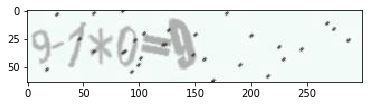

In [11]:
print(predict_with_bagging('train/79071.jpg'))
img = cv2.imread( rootpath+ 'train/79071.jpg')
plt.imshow(img)

(4-4)*1=1


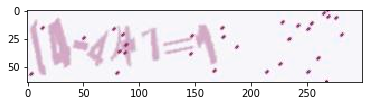

In [12]:
print(predict_with_bagging('train/35305.jpg'))
img = cv2.imread( rootpath+ 'train/35305.jpg')
plt.imshow(img)

8*(9*5)=360


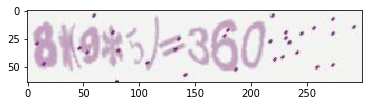

In [13]:

print(predict_with_bagging('train/63362.jpg'))
img = cv2.imread( rootpath+ 'train/63362.jpg')
plt.imshow(img)